# Downloads, crops and plot the TRMM Rainfall anomalies image for the last 30 days

[Nicolas Fauchereau](mailto:Nicolas.Fauchereau@niwa.co.nz)

In [10]:
%matplotlib inline

### imports the modules needed

In [11]:
import os, sys
from datetime import datetime, timedelta
from StringIO import StringIO
import requests
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

### defines the plotting function

In [21]:
def plot_trmm_from_images(img_arr, cbar_arr, paths, date):
    fig = plt.figure(figsize=(9.1,4.9))
    ax = fig.add_axes([0.03,0.05,0.95,0.9])

    ### date formatted 
    fdate = date.strftime('%Y-%B-%d')

    curr_map = Basemap(projection='cyl', llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat, \
                       resolution='h', ax=ax, area_thresh=10.)

    curr_map.imshow(img_arr,interpolation='bilinear', origin='upper')

    curr_map.drawcoastlines(linewidth=1.,color='k')
    #draw parallels and meridians.
    delat = 10.
    circles = np.arange(ll_lat,ur_lat + delat, delat)
    curr_map.drawparallels(circles, labels=[1,0,0,0], fontsize=14, linewidth=0.8, color='k')
    delon = 10.
    meridians = np.arange(ll_lon,ur_lon, delon)
    curr_map.drawmeridians(meridians, labels=[0,0,0,1], fontsize=14, linewidth=0.8, color='k')
    plt.title("TRMM rainfall anomalies for last 30 days ending %s" % (fdate))

    ### now load the colorbar image
    ax2 = fig.add_axes([0.61,-0.08,0.32,0.32], frameon=False)
    ### take the last 60 pixels (image originally 673 x 138)
    ax2.imshow(cbar_arr[-60:,:,:])
    plt.setp(ax2,xticks=[])
    plt.setp(ax2,yticks=[])

    for p in paths: 
        plt.savefig(os.path.join(p,'TRMM_last30days_anoms_{}'.format(fdate)), dpi=200)

### defines the paths to save the figure

In [22]:
dpaths = [os.path.join(os.environ['HOME'],'drives/auck_projects/ICU14101/Working/TRMM_KMLS/real_time'),\
          os.path.join(os.environ['HOME'], 'operational/ICU/TRMM_KMLS/SP')]

### defines the proxies (if needed)

In [23]:
proxies = {}
# proxies['http'] = 'http://proxy:port'

### date of today (UTC) - 1 day

In [24]:
date = datetime.now() - timedelta(days=1)

### definitions lat / lon

In [25]:
nlat = 400
nlon = 1440

### create lat and lon vectors
lon = np.arange(0.125, 0.125 + nlon * 0.25, 0.25) 
lat = np.arange(49.875, 49.875 - nlat * 0.25, -0.25)

### set the domain we want [lonW, lonE, latS, latN]
ll_lon, ur_lon, ll_lat, ur_lat = [135., 240., -50., 10.]

### defines URL, and streams the content

In [26]:
base_url = "http://trmm.gsfc.nasa.gov/trmm_rain/Events/"

In [27]:
r = requests.get(base_url + 'tafd_latest_google_earth_anomaly.png', proxies=proxies)
img = Image.open(StringIO(r.content))
img_arr = np.array(img)

r = requests.get(base_url + 'tafd_anomaly_google_wedge.png', proxies=proxies)
cbar = Image.open(StringIO(r.content))
cbar_arr = np.array(cbar)

### select domain

In [28]:
ilon = np.where( (lon >= ll_lon) & (lon <= ur_lon) )[0]
ilat = np.where( (lat >= ll_lat) & (lat <= ur_lat) )[0]

img_arr = np.take(np.take(img_arr,ilat,axis=0),ilon,axis=1)

img_arr[:,:,-1] = 255 # get rid of the transparency

### plots and saves the map

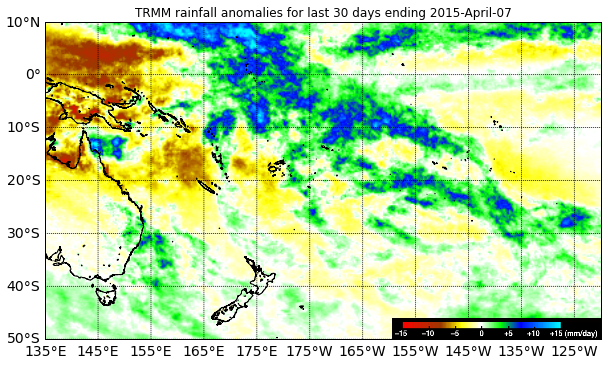

In [29]:
plot_trmm_from_images(img_arr, cbar_arr, dpaths, date)